In [0]:
!pip install opencv-python

     |█▉                    

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 61.8 MB 314 kB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-be973e20-9eb1-4de0-9393-457dda191e41/bin/python -m pip install --upgrade pip' command.


In [0]:
!pip install pytorch-lightning

     |████████████████████████████████| 825 kB 19.2 MB/s 
     |████████████████████████████████| 517 kB 83.4 MB/s 
     |████████████████████████████████| 1.0 MB 71.3 MB/s 
     |████████████████████████████████| 158 kB 106.5 MB/s 
     |████████████████████████████████| 264 kB 86.7 MB/s 
     |████████████████████████████████| 114 kB 95.7 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-be973e20-9eb1-4de0-9393-457dda191e41/bin/python -m pip install --upgrade pip' command.


In [0]:
#!pip install -U 'mlflow>=1.0.0'

In [0]:
train_path = '/dbfs/FileStore/data3a/training'
test_path = '/dbfs/FileStore/data3a/validation'


In [0]:
from torchvision.transforms import Compose, Resize, ToTensor, RandomAdjustSharpness, RandomHorizontalFlip, RandomRotation, Normalize
from transformers import ViTFeatureExtractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224") # helps to define transformations for vision transformer
normalize = Normalize(feature_extractor.image_mean, feature_extractor.image_std)
transformed = Compose([
    Resize((224, 224)),
    RandomHorizontalFlip(0.2),
    RandomRotation(20),
    RandomAdjustSharpness(sharpness_factor=2, p=0.8),
    ToTensor(),
    #normalize

])

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Out[6]: <matplotlib.image.AxesImage at 0x7fe4369192e0>

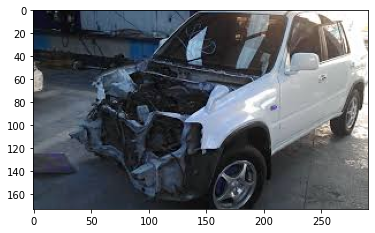

In [0]:
from PIL import Image
import os
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
random_pic = random.choice(os.listdir(train_path + '/' + '03-severe/'))
im = cv2.imread(train_path + '/03-severe/' + random_pic)
plt.imshow(im)

In [0]:
from torchvision.datasets import ImageFolder

train_folder = ImageFolder(train_path, transform=transformed)
test_folder = ImageFolder(test_path, transform=transformed)

In [0]:
from torch.utils.data import DataLoader
import numpy as np
import torch
# log batch size, learning rate, hidden layers number
# increase training set and log the number of rows of training sets, (epochs)
#dataset_subset = torch.utils.data.Subset(train_folder, np.random.choice(len(train_folder), 100, replace=False))
train_loader = DataLoader(train_folder, shuffle=True, batch_size=1)
test_loader = DataLoader(test_folder, batch_size = 64)

0
Out[9]: <matplotlib.image.AxesImage at 0x7fe41fa5af40>

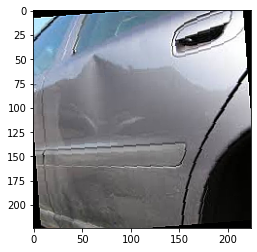

In [0]:
img, label = train_folder[0][0], train_folder[0][1]
import matplotlib.pyplot as plt
print(label)
plt.imshow(img.permute(1, 2, 0))

In [0]:
train_folder[0][0].shape

Out[10]: torch.Size([3, 224, 224])

In [0]:
import pytorch_lightning as pl
from torch import nn
from torch.optim import AdamW, SGD
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
import torchmetrics
from sklearn.metrics import confusion_matrix
import mlflow
from torch.nn import CrossEntropyLoss
from torchmetrics import Accuracy
from transformers import AutoModelForImageClassification, ResNetForImageClassification, ViTForImageClassification
import torchvision.models as models
class BaseModelV0(pl.LightningModule):
  def __init__(self, learning_rate):
    super().__init__()
    #self.train_acc = torchmetrics.Accuracy(task='multiclass')
    #self.valid_acc = torchmetrics.Accuracy(task='multiclass')
    self.learning_rate = learning_rate
    self.log("learning_rate", self.learning_rate, on_epoch=True, prog_bar=True)
    '''
    self.label2id = {"01-minor": 0,
                    "02-moderate": 1,
                    "03-severe": 2}
    self.id2label = {0: "01-minor", 
                    1: "02-moderate",
                    2: "03-severe"}
'''
    self.model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224",
                                                           num_labels=3,
                                                           id2label=self.id2label,
                                                           label2id=self.label2id,
                                                           ignore_mismatched_sizes=True
                                                           )
    
    '''
    backbone = models.resnet50(weights="DEFAULT")
    num_filters = backbone.fc.in_features
    layers = list(backbone.children())[:-1]
    self.feature_extractor = nn.Sequential(*layers)
'''
    # use the pretrained model to classify cifar-10 (10 image classes)

  def forward(self, x):
    return self.model(x).logits

  def configure_optimizers(self):
    # lower learning rate
    # higher learning rate => 0.4, 0.5, because training loss is not converging
    optimizer = SGD(self.parameters(), lr=self.learning_rate)
    # version 12
    return optimizer

  def train_dataloader(self):
    train_dir = ImageFolder(root=train_path, transform=transformed,target_transform=None)
    train_data = DataLoader(train_dir, batch_size=64, shuffle=True)
    return train_data
  def training_step(self, train_batch, batch_idx):
      acc = 0
      X, y = train_batch
      y_pred = self(X)
      loss = CrossEntropyLoss()
      loss_fn = loss(y_pred, y)

      accuracy = Accuracy(task="multiclass", num_classes=3)
      train_acc = accuracy(y_pred, y)
    
      return {"loss": loss_fn, "train_acc": train_acc}

  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    avg_train_acc = torch.stack([x["train_acc"] for x in outputs]).mean()
    self.log("avg_train_loss", avg_train_loss, on_step=False, on_epoch=True, prog_bar=True)
    self.log("avg_train_acc", avg_train_acc, on_step=False, on_epoch=True, prog_bar=True)

  def val_dataloader(self):
    test_dir = ImageFolder(root=test_path, transform=transformed,target_transform=None)
    test_data = DataLoader(test_dir, batch_size=64)
    return test_data
  def validation_step(self, test_batch, batch_idx):
      X, y = test_batch
      y_pred_test = self(X)
      loss = CrossEntropyLoss()
      loss_fn = loss(y_pred_test, y)
      accuracy = Accuracy("multiclass", num_classes=3)
      val_acc = accuracy(y_pred_test, y)
      
      
      return {"val_loss": loss_fn, "val_acc": val_acc}
  def validation_epoch_end(self, outputs):
    # accept list of outputs of validation loss and takes the average
    avg_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    avg_val_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
    self.log("avg_val_loss", avg_val_loss, on_step=False, on_epoch=True, prog_bar=True)
    self.log("avg_val_acc", avg_val_acc, on_step=False, on_epoch=True, prog_bar=True)


/databricks/python/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [0]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import mlflow

mlflow.pytorch.autolog()


# smaller dataset, more epochs
# weights adjusted every step or every batch
# accumulate batch 
early_stop_callback = EarlyStopping(monitor="avg_val_loss", patience = 50, verbose=True, mode="min", stopping_threshold=0.4)
trainer = Trainer(auto_lr_find=False, fast_dev_run=False, max_epochs=100, callbacks=[early_stop_callback], auto_scale_batch_size=False)

model = BaseModelV0(learning_rate=0.1)
#trainer.tune(model)



2023/02/13 14:47:07 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/local_disk0/.ephemeral_nfs/envs/pythonEnv-be973e20-9eb1-4de0-9393-457dda191e41/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-be973e20-9eb1-4de0-9393-457dda191e41/lib/python3.9/site-packages/pytorch_lightning/core/module.py:41

Downloading:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [0]:
import mlflow
experiment_name = "/Users/Ajay.Kamalakannan@edelmandxi.com/PyTorch_Projects/car-damage-detection-experiment"

#mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)
with mlflow.start_run() as run:
  trainer.fit(model=model)

---------------------------------------------------------------------------
The Python process exited with an unknown exit code.

The last 10 KB of the process's stderr and stdout can be found below. See driver logs for full logs.
---------------------------------------------------------------------------
Last messages on stderr:
Mon Feb 13 14:46:36 2023 Connection to spark from PID  1220
Mon Feb 13 14:46:36 2023 Initialized gateway on port 33809
Mon Feb 13 14:46:37 2023 Connected to spark.
/databricks/python/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
2023/02/13 14:47:07 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: T

In [0]:
import mlflow
mlflow.__version__

In [0]:
from torchmetrics import Accuracy

In [0]:
model.current_epoch

In [0]:
dir(trainer.callback_metrics)

In [0]:
dir(trainer)

In [0]:
'''
import mlflow.pyfunc

class FastTextWrapper(mlflow.pyfunc.PythonModel):
    """
    Class to train and use FastText Models
    """

    def load_context(self, context):
        """This method is called when loading an MLflow model with pyfunc.load_model(), as soon as the Python Model is constructed.
        Args:
            context: MLflow context where the model artifact is stored.
        """
        import fasttext

        self.model = torch.load_model(context.artifacts["model"])
        self.transformed = Compose([
        Resize((224, 224)),
        RandomHorizontalFlip(0.2),
        RandomRotation(20),
        RandomAdjustSharpness(sharpness_factor=2, p=0.8),
        ToTensor(),
        #normalize

                  ])

    def predict(self, context, model_input):
        """This is an abstract function. We customized it into a method to fetch the FastText model.
        Args:
            context ([type]): MLflow context where the model artifact is stored.
            model_input ([type]): the input data to fit into the model.
        Returns:
            [type]: the loaded model artifact.
        """
        return self.model
'''